# Fit Halo Mass from a Shear Catalog

_the LSST-DESC CLMM team_


This notebook demonstrates how to use `clmm` to estimate a WL halo mass from observations of a galaxy cluster. It uses several functionalities of the support `mock_data` module to produce datasets of increasing complexity. This notebook also demonstrates the bias introduced on the reconstructed mass by a naive fit, when the redshift distribution of the background galaxies is not properly accounted for in the model.

## Setup

First, we import some standard packages.

In [1]:
# For NumCosmo
import os
import gi

gi.require_version('NumCosmo', '1.0')
gi.require_version('NumCosmoMath', '1.0')
from gi.repository import GObject
from gi.repository import NumCosmo as Nc
from gi.repository import NumCosmoMath as Ncm


os.environ['CLMM_MODELING_BACKEND'] = 'nc'

__name__ = "NcContext"

Ncm.cfg_init ()
Ncm.cfg_set_log_handler (lambda msg: sys.stdout.write (msg) and sys.stdout.flush ())

In [2]:
import sys
sys.path.append('./support')
try: import clmm
except:
    import notebook_install
    notebook_install.install_clmm_pipeline(upgrade=False)
    import clmm
from astropy.cosmology import FlatLambdaCDM
import matplotlib.pyplot as plt
# %matplotlib inline
import numpy as np
from numpy import random
from sampler import fitters

clmm.__version__

'0.3.0'

Next, we import `clmm`'s core modules.

In [3]:
import clmm.polaraveraging as pa
import clmm.galaxycluster as gc
import clmm.modeling as modeling

We then import a support modules for a specific data sets.
`clmm` includes support modules that enable the user to generate mock data in a format compatible with `clmm`.

In [4]:
import mock_data as mock

## Making mock data

For reproducibility:

In [5]:
np.random.seed(11)

To create mock data, we need to define a true cosmology, which is currently done with [`astropy`'s cosmology library](http://docs.astropy.org/en/stable/cosmology/index.html).

In [6]:
mock_cosmo = FlatLambdaCDM(H0=70, Om0=0.27, Ob0=0.045)

We now set some parameters for a mock galaxy cluster.

In [7]:
cosmo = mock_cosmo
cluster_m = 1.e15
cluster_z = 0.3
concentration = 4
ngals = 10000
Delta = 200
cluster_ra = 0.0
cluster_dec = 0.0

Then we use the `mock_data` support module to generate 3 galaxy catalogs:
- `ideal_data`: all background galaxies at the same redshift.
- `ideal_data_z`: galaxies distributed according to the Chang et al. (2013) redshift distribution.
- `noisy_data_z`: `ideal_data_z` + photoz errors + shape noise

In [8]:
ideal_data = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, ngals, Delta,0.8)
ideal_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, ngals, Delta,'chang13')
noisy_data_z = mock.generate_galaxy_catalog(cluster_m, cluster_z, concentration, cosmo, ngals, Delta,'chang13', 
                                            shapenoise=0.05, 
                                            photoz_sigma_unscaled=0.05)

/home/sandro/Projects/CLMM/build/lib/clmm/modbackend/func_layer.py:433: UserWarning: Some source redshifts are lower than the cluster redshift. shear = 0 for those galaxies.
  warnings.warn(f'Some source redshifts are lower than the cluster redshift. shear = 0 for those galaxies.')


The galaxy catalogs are converted to a `clmm.GalaxyCluster` object and may be saved for later use.

In [9]:
cluster_id = "CL_ideal"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data)
gc_object.save('ideal_GC.pkl')

cluster_id = "CL_ideal_z"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, ideal_data_z)
gc_object.save('ideal_GC_z.pkl')

cluster_id = "CL_noisy_z"
gc_object = clmm.GalaxyCluster(cluster_id, cluster_ra, cluster_dec,
                               cluster_z, noisy_data_z)
gc_object.save('noisy_GC_z.pkl')

Any saved `clmm.GalaxyCluster` object may be read in for analysis.

In [10]:
cl1 = clmm.GalaxyCluster.load('ideal_GC.pkl') # all background galaxies at the same redshift
cl2 = clmm.GalaxyCluster.load('ideal_GC_z.pkl') # background galaxies distributed according to Chang et al. (2013)
cl3 = clmm.GalaxyCluster.load('noisy_GC_z.pkl') # same as cl2 but with photoz error and shape noise

print("Cluster info = ID:", cl2.unique_id, "; ra:", cl2.ra, "; dec:", cl2.dec, "; z_l :", cl2.z)
print("The number of source galaxies is :", len(cl2.galcat))

Cluster info = ID: CL_ideal_z ; ra: 0.0 ; dec: 0.0 ; z_l : 0.3
The number of source galaxies is : 10000


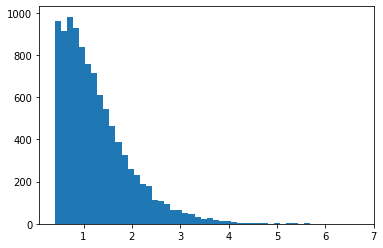

In [11]:
h = plt.hist(cl2.galcat['z'], bins=50)

## Deriving observables

### Computing shear

`clmm.polaraveraging.compute_shear` calculates the tangential and cross shears for each source galaxy in the cluster.

In [12]:
theta1, g_t1, g_x1 = cl1.compute_shear(geometry="flat")
theta2, g_t2, g_x2 = cl2.compute_shear(geometry="flat")
theta2, g_t3, g_x3 = cl3.compute_shear(geometry="flat")

### Radially binning the data

In [13]:
bin_edges = pa.make_bins(0.7, 4, 15, method='evenlog10width')

`clmm.polaraveraging.make_shear_profile` evaluates the average shear of the galaxy catalog in bins of radius.

In [14]:
profile1 = cl1.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)
profile2 = cl2.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)
profile3 = cl3.make_shear_profile("radians", "Mpc", bins=bin_edges,cosmo=cosmo)

After running `clmm.polaraveraging.make_shear_profile` on a `clmm.GalaxyCluster` object, the object acquires the `clmm.GalaxyCluster.profile` attribute.

In [15]:
for n in cl1.profile.colnames: cl1.profile[n].format = "%6.3e"
cl1.profile.pprint(max_width=-1)

radius_min   radius  radius_max     gt      gt_err      gx       gx_err      z       z_err     n_src  
---------- --------- ---------- --------- --------- ---------- --------- --------- --------- ---------
 7.000e-01 7.534e-01  7.863e-01 5.315e-02 2.245e-04 -1.468e-18 1.947e-18 8.000e-01 2.177e-17 2.600e+01
 7.863e-01 8.328e-01  8.831e-01 4.956e-02 1.850e-04  1.069e-18 1.439e-18 8.000e-01 1.734e-17 4.100e+01
 8.831e-01 9.295e-01  9.920e-01 4.571e-02 1.446e-04  1.804e-18 1.488e-18 8.000e-01 3.140e-17 5.000e+01
 9.920e-01 1.055e+00  1.114e+00 4.142e-02 1.410e-04  2.139e-19 4.685e-19 8.000e-01 1.484e-17 5.600e+01
 1.114e+00 1.188e+00  1.251e+00 3.758e-02 1.202e-04 -4.323e-19 5.606e-19 8.000e-01 1.241e-17 8.000e+01
 1.251e+00 1.327e+00  1.406e+00 3.416e-02 1.072e-04 -4.738e-19 7.160e-19 8.000e-01 1.121e-17 9.800e+01
 1.406e+00 1.492e+00  1.579e+00 3.071e-02 8.676e-05 -1.815e-19 4.753e-19 8.000e-01 1.933e-17 1.320e+02
 1.579e+00 1.682e+00  1.773e+00 2.740e-02 7.352e-05  6.933e-20 4.263e-19 

We visualize the radially binned shear for the 3 configurations

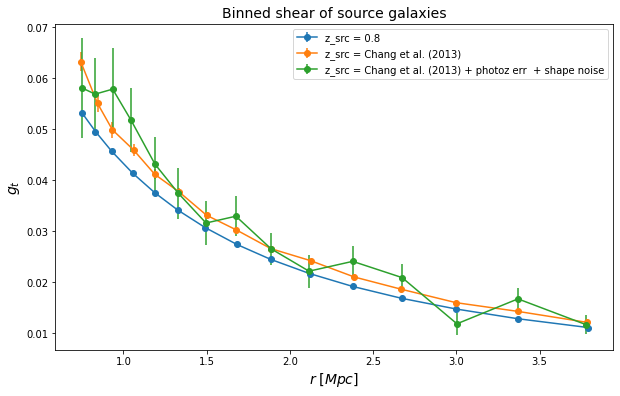

In [16]:
fig = plt.figure(figsize=(10, 6))


fsize = 14
fig.gca().errorbar(profile1['radius'], profile1['gt'], yerr=profile1['gt_err'], marker='o', label='z_src = 0.8')
fig.gca().errorbar(profile2['radius'], profile2['gt'], yerr=profile2['gt_err'], marker='o', 
                   label='z_src = Chang et al. (2013)')
fig.gca().errorbar(profile3['radius'], profile3['gt'], yerr=profile3['gt_err'], marker='o', 
                   label='z_src = Chang et al. (2013) + photoz err  + shape noise')

plt.gca().set_title(r'Binned shear of source galaxies', fontsize=fsize)
plt.gca().set_xlabel(r'$r\;[Mpc]$', fontsize=fsize)
plt.gca().set_ylabel(r'$g_t$', fontsize=fsize)
plt.legend()

## Create the halo model

`clmm.modeling.predict_reduced_tangential_shear` supports various parametric halo profile functions, including `nfw`.
Beware that the `clmm.modeling` module works in units of $\mathrm{Mpc}/h$, whereas the data is cosmology-independent, with units of $\mathrm{Mpc}$.

In [17]:
class GaussGammaTErr (Ncm.DataGaussDiag):
    z_cluster = GObject.Property (type = float, flags = GObject.PARAM_READWRITE)
    z_source  = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)
    r_source  = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)
    z_err     = GObject.Property (type = Ncm.Vector, flags = GObject.PARAM_READWRITE)

    def __init__ (self, z_cluster, r_source, z_source, gt_profile, gt_err, z_err = None, moo = None):
        Ncm.DataGaussDiag.__init__ (self, n_points = len (gt_profile))
        
        self.moo = moo if moo else clmm.Modeling ()
        
        assert len (gt_profile) == len (z_source)
        assert len (gt_profile) == len (r_source)
        assert len (gt_profile) == len (gt_err)
        
        self.set_size (len (gt_profile))
        
        self.props.z_cluster = z_cluster
        self.props.z_source  = Ncm.Vector.new_array (z_source)
        self.props.r_source  = Ncm.Vector.new_array (r_source)
        if z_err:
            self.props.r_source  = Ncm.Vector.new_array (z_err)
                
        self.y.set_array (gt_profile)
        
        self.sigma.set_array (gt_err)
        
        self.set_init (True)
    
    def do_get_length (self):
        return self.np

    def do_get_dof (self):
        return self.np

    def do_begin (self):
        pass

    def do_prepare (self, mset):
        self.moo.set_mset (mset)
        
    def do_mean_func (self, mset, vp):
        
        
        
        vp.set_array (self.moo.eval_reduced_shear (self.props.r_source.dup_array (), self.props.z_cluster, self.props.z_source.dup_array ()))
        return

GObject.type_register (GaussGammaTErr)

moo1 = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo1.set_cosmo_params_dict (clmm.modeling.cclify_astropy_cosmo (cosmo))
moo1.set_concentration (4.0)

moo2 = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo2.set_cosmo_params_dict (clmm.modeling.cclify_astropy_cosmo (cosmo))
moo2.set_concentration (4.0)

moo3 = clmm.Modeling (massdef = 'mean', delta_mdef = 200, halo_profile_model = 'nfw')
moo3.set_cosmo_params_dict (clmm.modeling.cclify_astropy_cosmo (cosmo))
moo3.set_concentration (4.0)

ggt1 = GaussGammaTErr (z_cluster = cluster_z, r_source = profile1['radius'] * cosmo.h, z_source = profile1['z'], gt_profile = profile1['gt'], gt_err = profile1['gt_err'], moo = moo1)
ggt2 = GaussGammaTErr (z_cluster = cluster_z, r_source = profile2['radius'] * cosmo.h, z_source = profile2['z'], gt_profile = profile2['gt'], gt_err = profile2['gt_err'], moo = moo2)
ggt3 = GaussGammaTErr (z_cluster = cluster_z, r_source = profile3['radius'] * cosmo.h, z_source = profile3['z'], gt_profile = profile3['gt'], gt_err = profile3['gt_err'], moo = moo3)

mset1 = ggt1.moo.get_mset ()
mset2 = ggt2.moo.get_mset ()
mset3 = ggt3.moo.get_mset ()

MDelta_pi = mset1.param_get_by_full_name ("NcHaloDensityProfile:MDelta")
cDelta_pi = mset1.param_get_by_full_name ("NcHaloDensityProfile:cDelta")

mset1.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset1.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FIXED)
mset1.prepare_fparam_map ()

mset2.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset2.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FIXED)
mset2.prepare_fparam_map ()

mset3.param_set_ftype (MDelta_pi.mid, MDelta_pi.pid, Ncm.ParamType.FREE)
mset3.param_set_ftype (cDelta_pi.mid, cDelta_pi.pid, Ncm.ParamType.FIXED)
mset3.prepare_fparam_map ()

dset1 = Ncm.Dataset.new ()
dset1.append_data (ggt1)
lh1 = Ncm.Likelihood.new (dset1)

dset2 = Ncm.Dataset.new ()
dset2.append_data (ggt2)
lh2 = Ncm.Likelihood.new (dset2)

dset3 = Ncm.Dataset.new ()
dset3.append_data (ggt3)
lh3 = Ncm.Likelihood.new (dset3)

fit1 = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh1, mset1, Ncm.FitGradType.NUMDIFF_FORWARD)
fit2 = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh2, mset2, Ncm.FitGradType.NUMDIFF_FORWARD)
fit3 = Ncm.Fit.new (Ncm.FitType.NLOPT, "ln-neldermead", lh3, mset3, Ncm.FitGradType.NUMDIFF_FORWARD)

fit1.run (Ncm.FitRunMsgs.SIMPLE)
fit1.fisher ()
fit1.log_covar ()

fit2.run (Ncm.FitRunMsgs.SIMPLE)
fit2.fisher ()
fit2.log_covar ()

fit3.run (Ncm.FitRunMsgs.SIMPLE)
fit3.fisher ()
fit3.log_covar ()


#----------------------------------------------------------------------------------
# Model fitting. Interating using:
#  - solver:            NLOpt:ln-neldermead
#  - differentiation:   Numerical differentiantion (forward)
#.............
#  Minimum found with precision: |df|/f =  1.00000e-08 and |dx| =  1.00000e-05
#  Elapsed time: 00 days, 00:00:00.0022990
#  iteration            [000046]
#  function evaluations [000048]
#  gradient evaluations [000000]
#  degrees of freedom   [000014]
#  m2lnL     =    0.138377633555858 (    0.13837763 )
#  Fit parameters:
#     1.43119140625e+15   
#----------------------------------------------------------------------------------
# NcmMSet parameters covariance matrix
#                                                  ----------------
# MDelta[04000:01] =  1.431e+15   +/-  1.234e+12   |  1           |
#                                                  ----------------
#-------------------------------------------------------------------------------

### Fitting a halo mass - highlighting bias when not accounting for the source redshift distribution in the model

We estimate the best-fit mass using `scipy.optimize.curve_fit`.

Here, to build the model we make the WRONG assumption that the average shear in bin $i$ equals the shear at the average redshift in the bin; i.e. we assume that $\langle g_t\rangle_i = g_t(\langle z\rangle_i)$. This should not impact `cluster 1` as all sources are located at the same redshift. However, this yields a bias in the econstructed mass for `cluster 2` and `cluster 3`, where the sources followed the Chang et al. (2013) distribution.

As expected, the reconstructed mass is biased whenever the sources are not located at a single redshift as this was not accounted for in the model.

## Visualization of the results

For visualization purpose, we calculate the reduced tangential shear predicted by the model when using the average redshift of the catalog.

In [18]:
rr = np.logspace(-0.5, np.log10(5), 100)

gt_model1 = moo1.eval_reduced_shear (rr*cosmo.h, cluster_z, np.mean(cl1.galcat['z']))
gt_model2 = moo2.eval_reduced_shear (rr*cosmo.h, cluster_z, np.mean(cl2.galcat['z']))
gt_model3 = moo3.eval_reduced_shear (rr*cosmo.h, cluster_z, np.mean(cl3.galcat['z']))

m_est1 = mset1.param_get (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h
m_est2 = mset2.param_get (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h
m_est3 = mset3.param_get (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h

m_est_err1 = fit1.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h
m_est_err2 = fit2.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h
m_est_err3 = fit3.covar_sd (MDelta_pi.mid, MDelta_pi.pid) * cosmo.h


We visualize that prediction of reduced tangential shear along with the data

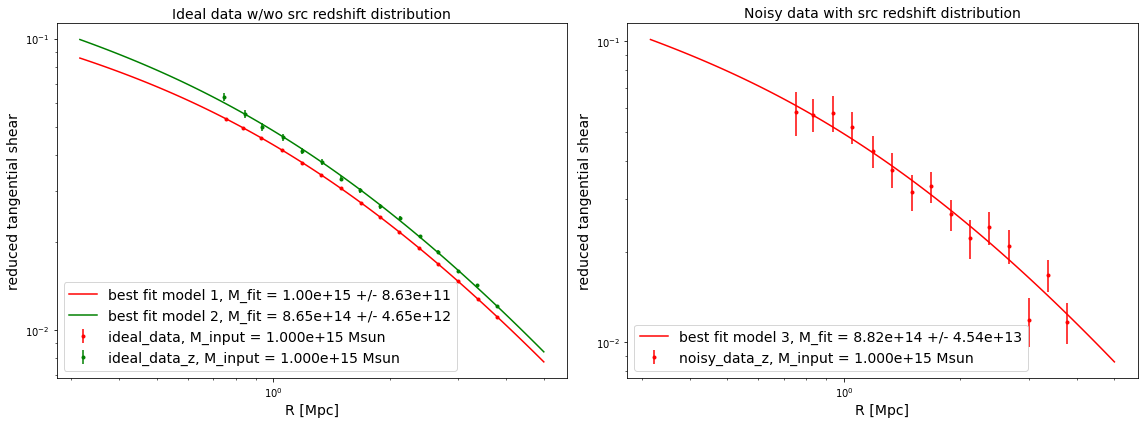

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

axes[0].errorbar(profile1['radius'], profile1['gt'],profile1['gt_err'], color='red',
                 label='ideal_data, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[0].plot(rr, gt_model1,color='red',
             label='best fit model 1, M_fit = %.2e +/- %.2e' % (m_est1, m_est_err1))


axes[0].errorbar(profile2['radius'], profile2['gt'],profile2['gt_err'], color='green',
                  label='ideal_data_z, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[0].plot(rr, gt_model2, color='green',
               label='best fit model 2, M_fit = %.2e +/- %.2e' % (m_est2, m_est_err2))
axes[0].set_title('Ideal data w/wo src redshift distribution',fontsize=fsize)
axes[0].semilogx()
axes[0].semilogy()
axes[0].legend(fontsize=fsize)
axes[0].set_xlabel('R [Mpc]', fontsize=fsize)
axes[0].set_ylabel('reduced tangential shear', fontsize=fsize)

axes[1].errorbar(profile3['radius'], profile3['gt'],profile3['gt_err'], color='red',
                label='noisy_data_z, M_input = %.3e Msun' % cluster_m, fmt='.')
axes[1].plot(rr, gt_model3,color='red',
             label='best fit model 3, M_fit = %.2e +/- %.2e' % (m_est3, m_est_err3))
axes[1].set_title('Noisy data with src redshift distribution',fontsize=fsize)
axes[1].semilogx()
axes[1].semilogy()
axes[1].legend(fontsize=fsize)
axes[1].set_xlabel('R [Mpc]', fontsize=fsize)
axes[1].set_ylabel('reduced tangential shear', fontsize=fsize)

fig.tight_layout()